In [24]:
# v1.11 - Нестандартные углы

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Цель: Добиться максимальной точности распознавания по X, Y, Z, R! - координаты плохие
# Цель: Распознавание вертикали машины (чтобы понял, что это перевернутая машина + не должны меняться данные, если изменение коснулось только по R)
# Цель: Поставить 3D - линии, чтобы понять,как распозналась машина
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# =========================================================
# Проблема: не распознал перевернутую машину
# =========================================================

# Все функции были перемещены в соответствующие ячейки:
# - rotate_image_and_boxes_back → Cell 4 (Повороты и маппинг координат)
# - canonicalize_orientation → Cell 5 (YOLO и оценка ориентации)
# - line_angle, line_abcd, intersect_two, vp_ransac, assign_axes, project_to_SO3, yaw_guess_from_single_vp, wrap180 → Cell 8 (Геометрия: линии, vanishing points, pose estimation)
# Установка
!pip -q install opencv-python-headless==4.10.0.84 ultralytics==8.3.39 pillow-heif pandas matplotlib

import math, json
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from ultralytics import YOLO
from google.colab import files
from PIL import Image, ImageOps
import pillow_heif
from io import BytesIO

pillow_heif.register_heif_opener()

CAR_CLASSES = {2, 3, 5, 7}

In [25]:
# Чтение любого изображения (JPEG/PNG/HEIC)
def read_image_auto(file_bytes: bytes):
    arr = np.frombuffer(file_bytes, np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    if img is not None:
        return img
    try:
        pil = Image.open(BytesIO(file_bytes))
        pil = ImageOps.exif_transpose(pil).convert("RGB")
        return cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print("HEIC read error:", repr(e))
        return None


# Детектор машин (YOLOv11l + тайлинг + NMS)

yolo = YOLO("yolo11n.pt")

# model = YOLO("yolo11n.pt")   # nano
# model = YOLO("yolo11s.pt")   # small
# model = YOLO("yolo11m.pt")   # medium
# model = YOLO("yolo11l.pt")   # large
# model = YOLO("yolo11x.pt")   # x-large

In [26]:
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a; bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1,bx1), max(ay1,by1)
    ix2, iy2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw*ih
    au = max(0,ax2-ax1)*max(0,ay2-ay1)
    bu = max(0,bx2-bx1)*max(0,by2-by1)
    return inter / (au + bu - inter + 1e-6)

def nms_union(boxes, thr=0.55):
    boxes = sorted(boxes, key=lambda x: x[4], reverse=True)
    kept=[]
    for b in boxes:
        if all(iou_xyxy(b[:4], k[:4]) <= thr for k in kept):
            kept.append(b)
    return kept

def merge_close_small(boxes, max_dist=6, max_size=26):
    """
    Склейка пачек очень мелких боксов, которые
    сидят почти в одной точке (типичная россыпь шума вдали).
    """
    small = []
    big = []
    for b in boxes:
        x1, y1, x2, y2, c = b
        w = x2 - x1
        h = y2 - y1
        if min(w, h) <= max_size:
            small.append(b)
        else:
            big.append(b)

    used = [False] * len(small)
    merged_small = []

    for i, b in enumerate(small):
        if used[i]:
            continue
        x1, y1, x2, y2, c = b
        cx = 0.5 * (x1 + x2)
        cy = 0.5 * (y1 + y2)

        group = [b]
        used[i] = True

        for j in range(i + 1, len(small)):
            if used[j]:
                continue
            x1b, y1b, x2b, y2b, cb = small[j]
            cxb = 0.5 * (x1b + x2b)
            cyb = 0.5 * (y1b + y2b)

            if abs(cxb - cx) <= max_dist and abs(cyb - cy) <= max_dist:
                group.append(small[j])
                used[j] = True

        xs1 = [g[0] for g in group]
        ys1 = [g[1] for g in group]
        xs2 = [g[2] for g in group]
        ys2 = [g[3] for g in group]
        conf = max(g[4] for g in group)

        merged_small.append((
            min(xs1),
            min(ys1),
            max(xs2),
            max(ys2),
            conf
        ))

    return big + merged_small


def filter_boxes_geom(boxes):
    """
    Отсев откровенного мусора по геометрии и уверенности
    без отрезания дальних машин по расстоянию.
    """
    filtered = []

    for (x1, y1, x2, y2, c) in boxes:
        w = x2 - x1
        h = y2 - y1
        if w <= 0 or h <= 0:
            continue

        s = min(w, h)
        ar = w / float(h)

        # совсем микроскопический бокс – ни ориентацию, ни расстояние не посчитать
        if s < 5:
            continue

        # слишком вытянутые: столбы, барьеры, части разметки
        if ar < 0.25 or ar > 5.0:
            continue

        # адаптивный порог по размеру:
        # чем меньше бокс, тем выше требование к conf
        if s < 10 and c < 0.25:
            continue
        if 10 <= s < 20 and c < 0.15:
            continue
        if s >= 20 and c < 0.08:
            continue

        filtered.append((x1, y1, x2, y2, c))

    # склейка россыпи мелких дублей в дальней зоне
    filtered = merge_close_small(filtered)

    return filtered

In [27]:
# Повороты и маппинг координат
def rotate_k90_bgr(img_bgr: np.ndarray, k: int) -> np.ndarray:
    k %= 4
    if k == 0:
        return img_bgr
    if k == 1:
        return cv2.rotate(img_bgr, cv2.ROTATE_90_CLOCKWISE)
    if k == 2:
        return cv2.rotate(img_bgr, cv2.ROTATE_180)
    return cv2.rotate(img_bgr, cv2.ROTATE_90_COUNTERCLOCKWISE)

def _rotate_point_k90(x: float, y: float, W: int, H: int, k: int):
    k %= 4
    if k == 0:
        return x, y, W, H
    if k == 1:  # CW
        return (H - 1 - y), x, H, W
    if k == 2:
        return (W - 1 - x), (H - 1 - y), W, H
    # CCW
    return y, (W - 1 - x), H, W

def bbox_rotate_k90(bbox_xyxy, W: int, H: int, k: int):
    x1, y1, x2, y2 = map(float, bbox_xyxy)
    pts = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    rpts = []
    nW, nH = W, H
    for (x, y) in pts:
        rx, ry, nW, nH = _rotate_point_k90(x, y, W, H, k)
        rpts.append((rx, ry))
    xs = [p[0] for p in rpts]
    ys = [p[1] for p in rpts]
    return [int(round(min(xs))), int(round(min(ys))), int(round(max(xs))), int(round(max(ys)))], nW, nH

def rotate_boxes_k90_back(boxes_rot, W_base, H_base, k_applied):
    """
    boxes_rot заданы в координатах изображения, полученного поворотом base на k_applied*90 (CW).
    Возвращает боксы в координатах base.
    """
    k = int(k_applied) % 4
    if k == 0:
        return boxes_rot

    # размеры изображения после поворота base на k
    Wr, Hr = (W_base, H_base) if (k % 2 == 0) else (H_base, W_base)
    k_inv = (-k) % 4

    out = []
    for (x1, y1, x2, y2, conf) in boxes_rot:
        bb0, _, _ = bbox_rotate_k90([x1, y1, x2, y2], Wr, Hr, k_inv)
        X1, Y1, X2, Y2 = bb0

        # зажим в границы base
        X1 = max(0, min(int(X1), W_base - 1))
        X2 = max(0, min(int(X2), W_base - 1))
        Y1 = max(0, min(int(Y1), H_base - 1))
        Y2 = max(0, min(int(Y2), H_base - 1))

        if (X2 - X1) < 2 or (Y2 - Y1) < 2:
            continue

        out.append((X1, Y1, X2, Y2, float(conf)))
    return out

def _rotate_bound(img_bgr: np.ndarray, angle_deg: float):
    """
    Поворот без обрезки (увеличивает холст).
    Возвращает: (rotated_img, M, (newW,newH))
    M: 2x3 аффинная матрица original -> rotated
    """
    h, w = img_bgr.shape[:2]
    if h < 2 or w < 2:
        return img_bgr, np.array([[1,0,0],[0,1,0]], dtype=np.float32), (w, h)

    cx, cy = w / 2.0, h / 2.0
    M = cv2.getRotationMatrix2D((cx, cy), float(angle_deg), 1.0).astype(np.float32)

    cos = abs(M[0, 0])
    sin = abs(M[0, 1])

    newW = int(h * sin + w * cos)
    newH = int(h * cos + w * sin)

    # сдвиг, чтобы картинка оказалась по центру нового холста
    M[0, 2] += (newW / 2.0) - cx
    M[1, 2] += (newH / 2.0) - cy

    rot = cv2.warpAffine(
        img_bgr, M, (newW, newH),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(114,114,114)
    )
    return rot, M, (newW, newH)

def _apply_affine_to_points(M2x3: np.ndarray, pts_xy: np.ndarray):
    pts = np.asarray(pts_xy, dtype=np.float32).reshape(-1, 2)
    ones = np.ones((pts.shape[0], 1), dtype=np.float32)
    pts_h = np.hstack([pts, ones])  # Nx3
    out = (M2x3 @ pts_h.T).T        # Nx2
    return out

def _map_boxes_from_rotated_to_base(boxes_rot, M_base_to_rot, W_base, H_base):
    """
    boxes_rot: list[(x1,y1,x2,y2,conf)] в координатах rotated
    Возвращает боксы в координатах base (исходного img_bgr) как axis-aligned bbox.
    """
    if not boxes_rot:
        return []

    Minv = cv2.invertAffineTransform(np.asarray(M_base_to_rot, dtype=np.float32))
    out = []
    for (x1,y1,x2,y2,conf) in boxes_rot:
        pts = np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]], dtype=np.float32)
        pts0 = _apply_affine_to_points(Minv, pts)
        xs = pts0[:,0]; ys = pts0[:,1]
        xx1 = int(np.floor(xs.min())); yy1 = int(np.floor(ys.min()))
        xx2 = int(np.ceil(xs.max()));  yy2 = int(np.ceil(ys.max()))

        # зажать в границы base
        xx1 = max(0, min(xx1, W_base - 1))
        yy1 = max(0, min(yy1, H_base - 1))
        xx2 = max(0, min(xx2, W_base - 1))
        yy2 = max(0, min(yy2, H_base - 1))

        if (xx2 - xx1) < 3 or (yy2 - yy1) < 3:
            continue
        out.append((xx1, yy1, xx2, yy2, float(conf)))
    return out

def rotate_image_and_boxes_back(img, angle_deg, boxes_rot):
    """
    Поворачивает изображение и боксы обратно на заданный угол.
    Используется для возврата координат боксов после поворота изображения.
    """
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle_deg, 1.0)
    Minv = cv2.invertAffineTransform(M)
    out = []
    for (x1,y1,x2,y2,conf) in boxes_rot:
        pts = np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]], dtype=np.float32)
        pts = np.hstack([pts, np.ones((4,1), np.float32)])
        pts = (Minv @ pts.T).T
        xs, ys = pts[:,0], pts[:,1]
        xx1, yy1, xx2, yy2 = int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())

        # жёстко зажимаем в границах изображения
        xx1 = max(0, min(xx1, w - 1))
        yy1 = max(0, min(yy1, h - 1))
        xx2 = max(0, min(xx2, w - 1))
        yy2 = max(0, min(yy2, h - 1))

        # отсеиваем совсем крошечные боксы – от них LSD всё равно толку нет
        if xx2 - xx1 < 6 or yy2 - yy1 < 6:
            continue

        out.append((xx1, yy1, xx2, yy2, conf))
    return out

def bbox_from_work_to_original(bbox_work_xyxy, W0: int, H0: int, rot_k: int):
    # work = rotate(original, rot_k CW). Чтобы вернуть обратно -> k_inv = -rot_k
    k_inv = (-rot_k) % 4
    Wr, Hr = (W0, H0) if (rot_k % 2 == 0) else (H0, W0)
    bbox0, _, _ = bbox_rotate_k90(bbox_work_xyxy, Wr, Hr, k_inv)
    # зажмём в границы
    x1, y1, x2, y2 = bbox0
    x1 = max(0, min(x1, W0 - 1))
    x2 = max(0, min(x2, W0 - 1))
    y1 = max(0, min(y1, H0 - 1))
    y2 = max(0, min(y2, H0 - 1))
    return [x1, y1, x2, y2]


In [28]:
#YOLO

def _run_yolo_cars(im_bgr, conf, iou, imgsz, max_det):
    r = yolo(im_bgr, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det, verbose=False)[0]
    boxes = []
    for b in r.boxes:
        if int(b.cls.item()) in CAR_CLASSES:
            x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().tolist()
            boxes.append((int(x1), int(y1), int(x2), int(y2), float(b.conf.item())))
    return boxes

def _estimate_deskew_angle_deg(img_bgr: np.ndarray, max_side: int = 960):
    """
    Оценка доминирующего угла линий в кадре (градусы в диапазоне [-90, 90)).
    Возвращает None, если линий мало/нет.
    """
    if img_bgr is None or img_bgr.size == 0:
        return None
    H, W = img_bgr.shape[:2]
    if H < 32 or W < 32:
        return None

    scale = 1.0
    work = img_bgr
    if max(H, W) > max_side:
        scale = max_side / float(max(H, W))
        work = cv2.resize(work, (max(2, int(W * scale)), max(2, int(H * scale))), interpolation=cv2.INTER_AREA)

    g = cv2.cvtColor(work, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g, (5, 5), 0)

    edges = cv2.Canny(g, 50, 150)
    m = max(work.shape[:2])
    min_len = int(0.10 * m)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180.0, threshold=80, minLineLength=min_len, maxLineGap=12)

    if lines is None or len(lines) < 10:
        return None

    hist = np.zeros(180, dtype=np.float64)  # bins for [-90..+90)
    for x1, y1, x2, y2 in lines.reshape(-1, 4):
        dx = float(x2 - x1)
        dy = float(y2 - y1)
        L = math.hypot(dx, dy)
        if L < 1.0:
            continue
        ang = math.degrees(math.atan2(dy, dx))
        while ang >= 90.0:
            ang -= 180.0
        while ang < -90.0:
            ang += 180.0
        idx = int(round(ang + 90.0))
        idx = 0 if idx < 0 else (179 if idx > 179 else idx)
        hist[idx] += L

    if hist.max() <= 0:
        return None

    peak = int(hist.argmax())
    return float(peak - 90.0)


def _quick_score_for_angle(img_bgr, angle_deg, conf=0.18, iou=0.5, imgsz=640, max_det=120):
    rot, M, _ = _rotate_bound(img_bgr, angle_deg)
    try:
        boxes = _run_yolo_cars(rot, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det)
    except Exception:
        return -1e9, angle_deg
    n = len(boxes)
    sconf = sum([b[4] for b in boxes]) if n else 0.0
    # скор: количество + суммарная уверенность
    return (25.0 * n + 10.0 * sconf), angle_deg

def _pick_angles_for_rescue(img_bgr, step_deg=15, topk=3):
    """
    Ищет лучшие углы по быстрому YOLO-скору.
    Возвращает список углов в градусах (могут быть дробные).
    """
    scores = []
    for a in range(0, 360, int(step_deg)):
        sc, ang = _quick_score_for_angle(img_bgr, a)
        scores.append((sc, ang))
    scores.sort(key=lambda x: x[0], reverse=True)

    chosen = []
    for sc, ang in scores:
        if len(chosen) >= int(topk):
            break
        # не брать углы, слишком близкие к уже выбранным
        ok = True
        for c in chosen:
            d = abs(((ang - c + 180) % 360) - 180)
            if d < step_deg * 0.75:
                ok = False
                break
        if ok:
            chosen.append(float(ang))

    # локальное уточнение вокруг найденных пиков
    refined = []
    for a in chosen:
        refined.extend([a, a - 7.0, a + 7.0])

    # нормализация в [-180, 180)
    out = []
    for a in refined:
        aa = ((float(a) + 180.0) % 360.0) - 180.0
        out.append(aa)
    # убрать дубли
    out_u = []
    for a in out:
        if all(abs(((a - b + 180) % 360) - 180) > 1.0 for b in out_u):
            out_u.append(a)
    return out_u

#?????
def _quick_yolo_car_score(img_bgr, conf=0.15, iou=0.5, imgsz=960, max_det=200):
    """
    Быстрый прогон YOLO для выбора ориентации кадра.
    Возвращает (count, sum_conf).
    """
    try:
        r = yolo(img_bgr, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det, verbose=False)[0]
    except Exception:
        return 0, 0.0

    cnt = 0
    sconf = 0.0
    for b in r.boxes:
        if int(b.cls.item()) in CAR_CLASSES:
            c = float(b.conf.item())
            cnt += 1
            sconf += c
    return cnt, sconf

def global_vps_detailed(img_bgr, max_side=1024):
    H, W = img_bgr.shape[:2]
    if H < 2 or W < 2:
        return {"score": -1, "vp1": None, "vp2": None, "f": None, "counts": [0, 0, 0]}

    scale = 1.0
    work = img_bgr
    if max(H, W) > max_side:
        scale = max_side / float(max(H, W))
        work = cv2.resize(
            img_bgr,
            (max(2, int(W * scale)), max(2, int(H * scale))),
            interpolation=cv2.INTER_AREA
        )

    h, w = work.shape[:2]
    L_raw = lsd_lines(work)
    groups = cluster_angles(L_raw, k=3)

    vps = []
    counts = []
    for g in groups:
        g = np.asarray(g, dtype=np.float32)
        counts.append(int(len(g)))
        vps.append(vanishing_point(g) if len(g) >= 10 else None)

    cx, cy = w / 2.0, h / 2.0
    best = None
    best_score = -1

    for i in range(3):
        for j in range(i + 1, 3):
            vi, vj = vps[i], vps[j]
            if vi is None or vj is None:
                continue

            ux1, uy1 = vi[0] - cx, vi[1] - cy
            ux2, uy2 = vj[0] - cx, vj[1] - cy
            f2 = -(ux1 * ux2 + uy1 * uy2)

            if not (np.isfinite(f2) and f2 > 1e-6):
                continue

            f = math.sqrt(float(f2))
            m = max(w, h)
            if not (0.2 * m <= f <= 5.0 * m):
                continue

            score = counts[i] + counts[j]
            if score > best_score:
                best_score = score
                best = (vi, vj, f)

    if best is None:
        return {"score": -1, "vp1": None, "vp2": None, "f": None, "counts": counts}

    vp1_s, vp2_s, f_s = best
    inv = 1.0 / scale
    vp1 = (vp1_s[0] * inv, vp1_s[1] * inv)
    vp2 = (vp2_s[0] * inv, vp2_s[1] * inv)
    f = float(f_s * inv)

    return {"score": int(best_score), "vp1": vp1, "vp2": vp2, "f": f, "counts": counts}

def estimate_k90_by_vps(img_bgr: np.ndarray) -> int:
    best_k = 0
    best_score = -1
    for k in range(4):
        rot = rotate_k90_bgr(img_bgr, k)
        det = global_vps_detailed(rot, max_side=1024)
        sc = det["score"]
        if sc > best_score:
            best_score = sc
            best_k = k
    return best_k

def estimate_k90_auto(img_bgr: np.ndarray) -> int:
    """
    Выбор ориентации 0/90/180/270 по совмещённому скору:
    - геометрия (global_vps_detailed.score)
    - YOLO (count и sum_conf по классам CAR_CLASSES)
    """
    best_k = 0
    best_score = -1e18

    for k in range(4):
        rot = rotate_k90_bgr(img_bgr, k)

        det = global_vps_detailed(rot, max_side=1024)
        vp_score = float(det.get("score", -1))

        ncar, sconf = _quick_yolo_car_score(rot, conf=0.15, imgsz=960, max_det=200)

        # весовые коэффициенты подобраны так, чтобы YOLO мог “спасти” кадр,
        # когда vp_score везде плохой/отрицательный
        geom_term = (vp_score if vp_score >= 0 else -5.0)
        yolo_term = 25.0 * float(ncar) + 10.0 * float(sconf)

        score = geom_term + yolo_term

        if score > best_score:
            best_score = score
            best_k = k

    return int(best_k)

def canonicalize_orientation(img_bgr: np.ndarray):
    """
    Канонизирует ориентацию изображения: поворачивает к оптимальной ориентации (0/90/180/270).
    Возвращает выровненное изображение и применённый поворот.
    """
    rot_k = estimate_k90_by_vps(img_bgr)
    img_work = rotate_k90_bgr(img_bgr, rot_k)
    return img_work, rot_k




In [29]:
# идея: 1 машина = 1 бокс
def _containment_suppression(boxes, contain_thr=0.92, conf_margin=0.02):
    """
    Удаляет бокс B, если он почти полностью внутри A и A не слабее по conf.
    contain_thr: доля площади B, покрытая пересечением с A.
    """
    if not boxes:
        return []

    # сортировка по уверенности убыв.
    bxs = sorted(boxes, key=lambda x: x[4], reverse=True)
    keep = []
    for b in bxs:
        x1,y1,x2,y2,cb = b
        area_b = max(0, x2-x1) * max(0, y2-y1)
        if area_b <= 0:
            continue

        drop = False
        for a in keep:
            ax1,ay1,ax2,ay2,ca = a
            ix1, iy1 = max(x1,ax1), max(y1,ay1)
            ix2, iy2 = min(x2,ax2), min(y2,ay2)
            iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
            inter = iw*ih
            if inter <= 0:
                continue

            cover = inter / (area_b + 1e-9)
            if cover >= contain_thr and ca + conf_margin >= cb:
                drop = True
                break

        if not drop:
            keep.append(b)
    return keep
def _box_area(b):
    return max(0, int(b[2]) - int(b[0])) * max(0, int(b[3]) - int(b[1]))

def _box_center(b):
    return (0.5 * (float(b[0]) + float(b[2])), 0.5 * (float(b[1]) + float(b[3])))

def _box_min_side(b):
    return float(min(max(0, int(b[2]) - int(b[0])), max(0, int(b[3]) - int(b[1]))))

def _containment_cover(a, b):
    """
    Доля площади b, покрытая пересечением с a.
    Если a почти содержит b -> значение близко к 1.
    """
    ax1, ay1, ax2, ay2 = map(float, a[:4])
    bx1, by1, bx2, by2 = map(float, b[:4])

    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0.0, ix2 - ix1), max(0.0, iy2 - iy1)
    inter = iw * ih
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    if area_b <= 1e-9:
        return 0.0
    return float(inter / area_b)

def _pick_better_box(a, b, conf_margin=0.03):
    """
    Выбор "лучшего" бокса среди двух дублей.
    Если conf почти равны -> берём меньшую площадь (обычно точнее).
    """
    ca = float(a[4]); cb = float(b[4])
    if ca > cb + conf_margin:
        return a
    if cb > ca + conf_margin:
        return b
    return a if _box_area(a) <= _box_area(b) else b

def _drop_big_if_contains_small(boxes, contain_thr=0.92, conf_margin=0.03, area_ratio=1.6):
    """
    Удаляет БОЛЬШОЙ бокс, если он почти содержит маленький,
    и маленький не хуже по conf (или большой сильно больше по площади).
    Это убирает типичную ситуацию: один объект + огромный "фоновой" дубль.
    """
    if not boxes:
        return []
    bxs = sorted(boxes, key=lambda b: _box_area(b))  # от меньших к большим
    alive = [True] * len(bxs)

    for i in range(len(bxs)):
        if not alive[i]:
            continue
        small = bxs[i]
        a_small = _box_area(small)
        if a_small <= 0:
            continue

        for j in range(i + 1, len(bxs)):
            if not alive[j]:
                continue
            big = bxs[j]
            a_big = _box_area(big)
            if a_big <= 0:
                alive[j] = False
                continue

            if _containment_cover(big, small) >= contain_thr:
                # big содержит small
                if (float(small[4]) >= float(big[4]) - conf_margin) or (a_big >= area_ratio * a_small):
                    alive[j] = False

    return [bxs[i] for i in range(len(bxs)) if alive[i]]

def _same_object(a, b, iou_thr=0.20, center_thr=0.45, area_ratio_min=0.35, area_ratio_max=2.8, contain_thr=0.92):
    """
    Считает боксы дублями одного объекта, даже если IoU "не дотягивает"
    из-за поворотов/обратного маппинга.
    """
    ia = float(iou_xyxy(a[:4], b[:4]))
    if ia >= iou_thr:
        return True

    # containment в обе стороны
    if _containment_cover(a, b) >= contain_thr:
        return True
    if _containment_cover(b, a) >= contain_thr:
        return True

    aa = _box_area(a); ab = _box_area(b)
    if aa <= 0 or ab <= 0:
        return False

    r = aa / (ab + 1e-9)
    if r < area_ratio_min or r > area_ratio_max:
        return False

    (cx1, cy1) = _box_center(a)
    (cx2, cy2) = _box_center(b)
    dist = math.hypot(cx1 - cx2, cy1 - cy2)

    scale = max(6.0, 0.5 * (_box_min_side(a) + _box_min_side(b)))
    return dist <= center_thr * scale

def dedup_one_box_per_car(
    boxes,
    nms_thr=0.45,
    contain_thr=0.92,
    conf_margin=0.03,
    center_thr=0.45
):
    """
    Гарантирует "1 машина = 1 бокс" для итогового списка.
    """
    if not boxes:
        return []

    # выкидываем мусор и шум, который не нужен для ориентации/геометрии
    boxes = filter_boxes_geom(boxes)

    # жёсткое IoU-NMS (строже вашего 0.55)
    boxes = nms_union(boxes, thr=float(nms_thr))

    # убираем огромные дубли, которые содержат нормальные маленькие
    boxes = _drop_big_if_contains_small(boxes, contain_thr=contain_thr, conf_margin=conf_margin, area_ratio=1.6)

    # убираем маленькие дубли внутри сильных больших
    boxes = _containment_suppression(boxes, contain_thr=contain_thr, conf_margin=0.02)

    # кластеризация по "похожести" (IoU/центр/containment)
    boxes = sorted(boxes, key=lambda b: float(b[4]), reverse=True)
    kept = []
    for b in boxes:
        merged = False
        for k_idx in range(len(kept)):
            k = kept[k_idx]
            if _same_object(b, k, iou_thr=0.20, center_thr=center_thr, contain_thr=contain_thr):
                kept[k_idx] = _pick_better_box(b, k, conf_margin=conf_margin)
                merged = True
                break
        if not merged:
            kept.append(b)

    # финальный контрольный NMS
    kept = nms_union(kept, thr=max(0.35, float(nms_thr) - 0.05))
    return kept


In [30]:
def detect_all_cars(
    img_bgr,
    conf=0.05,
    iou=0.5,
    imgsz=1984,
    max_det=1000,
    do_deskew_rescue=True,
    rescue_refine_deg=(0.0, 12.0, -12.0, 24.0, -24.0),  # расширенный диапазон подстройки
    rescue_axes_deg=(0.0, 90.0),                        # пробуем выровнять доминирующие линии в 0° и в 90°
    add_90_270_if_few=True,
    few_thr=4,                                          # если после 0/180 "нормальных" боксов мало, включить 90/270
    good_min_side=14,                                   # "нормальность" бокса для триггера 90/270
    large_min_side=80,                                  # порог для крупных объектов (нужна более тщательная проверка)
    do_containment=True,
    extended_angle_search=True                          # расширенный поиск углов для крупных объектов
):
    """
    Улучшенная версия detect_all_cars с поддержкой нестандартных углов:
    - 0° + 180° всегда
    - опционально 90/270, если мало "нормальных" боксов
    - произвольный угол: deskew-rescue по доминирующим линиям кадра (Хафф)
    - расширенный поиск углов для крупных объектов
    - NMS + containment suppression + filter_boxes_geom
    """
    H, W = img_bgr.shape[:2]
    if H < 2 or W < 2:
        return []

    boxes = []

    # 0°
    boxes += _run_yolo_cars(img_bgr, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det)

    # 180° (через k90, без обрезки)
    rot180 = rotate_k90_bgr(img_bgr, 2)
    b180 = _run_yolo_cars(rot180, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det)
    boxes += rotate_boxes_k90_back(b180, W, H, 2)

    # быстрый подсчёт "нормальных" и "крупных" боксов после грубого NMS
    tmp = nms_union(boxes, thr=0.5)
    good = 0
    large_count = 0
    for x1, y1, x2, y2, c in tmp:
        min_side = min((x2 - x1), (y2 - y1))
        if min_side >= int(good_min_side):
            good += 1
        if min_side >= int(large_min_side):
            large_count += 1

    # 90/270 как страховка, если реально мало нормальных объектов
    if add_90_270_if_few and good <= int(few_thr):
        rot90 = rotate_k90_bgr(img_bgr, 1)
        b90 = _run_yolo_cars(rot90, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det)
        boxes += rotate_boxes_k90_back(b90, W, H, 1)

        rot270 = rotate_k90_bgr(img_bgr, 3)
        b270 = _run_yolo_cars(rot270, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det)
        boxes += rotate_boxes_k90_back(b270, W, H, 3)

    # произвольный угол: выравнивание доминирующих линий (для кадров 10/45/60/172 и т.п.)
    if do_deskew_rescue:
        ang = _estimate_deskew_angle_deg(img_bgr, max_side=960)
        if ang is not None and np.isfinite(ang):
            # хотим повернуть так, чтобы доминирующий угол стал 0° или 90°
            for axis in rescue_axes_deg:
                base_rot = float(axis) - float(ang)
                for d in rescue_refine_deg:
                    a = float(base_rot + d)

                    # убрать почти дубли 0/180/90/270
                    def _near(k):
                        return abs(((a - k + 180.0) % 360.0) - 180.0) < 3.0
                    if _near(0.0) or _near(90.0) or _near(180.0) or _near(-90.0):
                        continue

                    rot, M, _ = _rotate_bound(img_bgr, a)
                    br = _run_yolo_cars(rot, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det)
                    boxes += _map_boxes_from_rotated_to_base(br, M, W, H)

    # Расширенный поиск углов для крупных объектов при нестандартных углах
    tmp2 = nms_union(boxes, thr=0.5)
    good2 = 0
    large_count2 = 0
    for x1, y1, x2, y2, c in tmp2:
        min_side = min((x2 - x1), (y2 - y1))
        if min_side >= int(good_min_side):
            good2 += 1
        if min_side >= int(large_min_side):
            large_count2 += 1

    # Если крупных объектов мало или общее количество мало - более агрессивный поиск
    need_extended_search = (large_count2 < 2) or (good2 <= int(few_thr * 1.5))

    if need_extended_search and extended_angle_search:
        # Дополнительный поиск углов через YOLO-скоринг
        for a in _pick_angles_for_rescue(img_bgr, step_deg=15, topk=4):
            # убрать почти дубли 0/180/90/270
            if abs(((a - 0.0 + 180.0) % 360.0) - 180.0) < 3.0:
                continue
            if abs(((a - 90.0 + 180.0) % 360.0) - 180.0) < 3.0:
                continue
            if abs(((a - 180.0 + 180.0) % 360.0) - 180.0) < 3.0:
                continue
            if abs(((a - (-90.0) + 180.0) % 360.0) - 180.0) < 3.0:
                continue

            rot, M, _ = _rotate_bound(img_bgr, a)
            br = _run_yolo_cars(rot, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det)
            boxes += _map_boxes_from_rotated_to_base(br, M, W, H)

        # Дополнительная проверка для крупных объектов: проверяем больше углов с меньшим шагом
        if large_count2 < 1:
            # Проверяем углы с шагом 10° для поиска крупных объектов
            additional_angles = []
            for base_ang in range(0, 360, 10):
                # Пропускаем стандартные углы
                if abs(((base_ang - 0.0 + 180.0) % 360.0) - 180.0) < 5.0:
                    continue
                if abs(((base_ang - 90.0 + 180.0) % 360.0) - 180.0) < 5.0:
                    continue
                if abs(((base_ang - 180.0 + 180.0) % 360.0) - 180.0) < 5.0:
                    continue
                if abs(((base_ang - 270.0 + 180.0) % 360.0) - 180.0) < 5.0:
                    continue
                additional_angles.append(float(base_ang))

            # Проверяем топ-6 дополнительных углов
            scores_angles = []
            for a in additional_angles[:12]:  # ограничиваем для производительности
                rot, M, _ = _rotate_bound(img_bgr, a)
                br = _run_yolo_cars(rot, conf=conf * 0.8, iou=iou, imgsz=imgsz, max_det=max_det)  # чуть ниже порог для крупных
                # Подсчитываем количество крупных боксов
                large_found = sum(1 for x1, y1, x2, y2, c in br if min((x2 - x1), (y2 - y1)) >= large_min_side * 0.8)
                if large_found > 0:
                    scores_angles.append((large_found, a))

            # Сортируем и берём лучшие углы
            scores_angles.sort(reverse=True)
            for _, a in scores_angles[:4]:  # топ-4 угла
                rot, M, _ = _rotate_bound(img_bgr, a)
                br = _run_yolo_cars(rot, conf=conf, iou=iou, imgsz=imgsz, max_det=max_det)
                boxes += _map_boxes_from_rotated_to_base(br, M, W, H)

    # финальная дедупликация: 1 машина = 1 бокс
    boxes = dedup_one_box_per_car(
        boxes,
        nms_thr=0.45,
        contain_thr=0.92,
        conf_margin=0.03,
        center_thr=0.45
    )
    return boxes

In [31]:
# Вспомогательные функции для работы с углами и геометрией
def wrap180(a: float) -> float:
    """Нормализует угол в диапазон [-180, 180) градусов."""
    a = ((float(a) + 180.0) % 360.0) - 180.0
    return a

# Функции для работы с линиями
def line_angle(x1, y1, x2, y2):
    """Вычисляет угол линии в радианах, нормализованный в [-π/2, π/2)."""
    ang = math.atan2(y2 - y1, x2 - x1)
    if ang > math.pi / 2:
        ang -= math.pi
    if ang < -math.pi / 2:
        ang += math.pi
    return ang

def line_abcd(l):
    """Преобразует линию (x1, y1, x2, y2) в нормализованное уравнение прямой ax + by + c = 0."""
    x1, y1, x2, y2 = l
    a = y1 - y2
    b = x2 - x1
    c = x1 * y2 - x2 * y1
    s = math.hypot(a, b) + 1e-9
    return a / s, b / s, c / s

def intersect_two(l1, l2):
    """Находит точку пересечения двух линий. Возвращает None, если линии параллельны."""
    a1, b1, c1 = line_abcd(l1)
    a2, b2, c2 = line_abcd(l2)
    det = a1 * b2 - a2 * b1
    if abs(det) < 1e-8:
        return None
    x = (b1 * (-c2) - b2 * (-c1)) / det
    y = (a2 * (-c1) - a1 * (-c2)) / det
    return (float(x), float(y))

def vp_ransac(lines, iters=900):
    """Находит vanishing point (точку схода) используя RANSAC алгоритм."""
    lines = np.asarray(lines, dtype=np.float32)
    n = len(lines)
    if n < 3:
        return None

    # веса по длине отрезка (длинные линии важнее)
    w = np.hypot(lines[:, 2] - lines[:, 0], lines[:, 3] - lines[:, 1]).astype(np.float64)
    w = w / (w.sum() + 1e-12)

    best_err = 1e30
    best = None

    for _ in range(iters):
        # выбираем 2 разных линии с вероятностью ~ длине
        i = int(np.random.choice(n, p=w))
        j = int(np.random.choice(n, p=w))
        if i == j:
            continue

        p = intersect_two(lines[i], lines[j])
        if p is None:
            continue
        x, y = p
        if (not np.isfinite(x)) or (not np.isfinite(y)):
            continue

        # взвешенная L1-ошибка "точка до прямой"
        err = 0.0
        for k in range(n):
            a, b, c = line_abcd(lines[k])
            err += w[k] * abs(a * x + b * y + c)

        if err < best_err:
            best_err = err
            best = (float(x), float(y))

    return best

def assign_axes(groups, bbox, offset_xy):
    """Назначает оси (length, width, height) для групп линий на основе их углов."""
    x1, y1, x2, y2 = bbox
    vps = []
    means = []
    for g in groups:
        vps.append(vanishing_point(g))
        if len(g) == 0:
            means.append(999.0)
        else:
            means.append(np.median([abs(math.degrees(line_angle(*l))) for l in g]))
    idx_height = int(np.argmax(means))
    idx_length = int(np.argmin(means))
    idx_width = list({0, 1, 2} - {idx_height, idx_length})[0] if len(groups) == 3 else None
    vp_len = vps[idx_length]
    vp_wid = vps[idx_width] if idx_width is not None else None
    ox, oy = offset_xy
    if vp_len is not None:
        vp_len = (vp_len[0] + ox, vp_len[1] + oy)
    if vp_wid is not None:
        vp_wid = (vp_wid[0] + ox, vp_wid[1] + oy)
    return vp_len, vp_wid

# Функции для работы с поворотами и матрицами
def project_to_SO3(R):
    """Проецирует матрицу R в SO(3) (специальную ортогональную группу) используя SVD."""
    if R is None or not np.all(np.isfinite(R)):
        return None
    try:
        U, S, Vt = np.linalg.svd(R)
        Rso = U @ Vt
        if np.linalg.det(Rso) < 0:
            Vt[-1, :] *= -1
            Rso = U @ Vt
        return Rso
    except np.linalg.LinAlgError:
        return None

def yaw_guess_from_single_vp(vp, cx, cy, f):
    """Оценивает yaw (рыскание) из одной vanishing point."""
    if vp is None or f is None or (not np.isfinite(f)) or f <= 1e-6:
        return None
    dx = (float(vp[0]) - cx) / f
    dz = 1.0
    yaw = math.degrees(math.atan2(dx, dz))
    yaw = ((yaw + 180) % 360) - 180
    return None if not np.isfinite(yaw) else yaw

# Геометрия: ROI, линии, vanishing points
def make_lsd_roi(img_bgr, bbox,
                 min_small=64, min_medium=160,
                 pad_small=1.0, pad_medium=0.4, pad_big=0.1):
    H, W = img_bgr.shape[:2]
    x1, y1, x2, y2 = map(int, bbox)
    w = x2 - x1
    h = y2 - y1
    if w <= 0 or h <= 0:
        return None, (0, 0)

    s = min(w, h)

    if s < min_small:
        k = pad_small      # маленькие → сильно расширяем
    elif s < min_medium:
        k = pad_medium     # средние → чуть
    else:
        k = pad_big        # большие → почти не трогаем

    dx = int(w * k)
    dy = int(h * k)

    rx1 = max(0, x1 - dx)
    ry1 = max(0, y1 - dy)
    rx2 = min(W, x2 + dx)
    ry2 = min(H, y2 + dy)

    roi = img_bgr[ry1:ry2, rx1:rx2]
    if roi is None or roi.size == 0:
        return None, (rx1, ry1)

    return roi, (rx1, ry1)

# In-plane угол
def inplane_angle(img, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    roi = img[y1:y2, x1:x2]
    if roi is None or roi.size == 0:
        return None

    h, w = roi.shape[:2]
    # Это не "ограничение", это физическая невозможность: на 1-2 пикселях OpenCV-операции не имеют смысла.
    if h < 2 or w < 2:
        return None

    def angle_from_points_xy(xs, ys):
        if xs is None or ys is None:
            return None
        if len(xs) < 20:
            return None
        pts = np.column_stack([xs, ys]).astype(np.float32)
        r = cv2.minAreaRect(pts)
        (wB, hB), a = r[1], r[-1]
        if wB <= 1 or hB <= 1:
            return None
        ang = float(a)
        if wB < hB:
            ang = ang + 90.0
        if ang > 90.0:
            ang -= 180.0
        if ang < -90.0:
            ang += 180.0
        return ang

    # Быстрый путь: контуры/границы (обычно быстрее GrabCut)
    g = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    g = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(g)
    e = cv2.Canny(g, 0, 255)
    ys, xs = np.where(e > 0)
    a = angle_from_points_xy(xs, ys)
    if a is not None:
        return a

    # Медленный путь: GrabCut, только если быстрый не сработал
    # (если ROI совсем маленький, grabcut может бросать исключение — обработаем)
    mask = np.zeros((h, w), np.uint8)
    bg, fg = np.zeros((1, 65), np.float64), np.zeros((1, 65), np.float64)
    rect = (max(0, w // 20), max(0, h // 20), max(1, w - 2 * w // 20), max(1, h - 2 * h // 20))
    try:
        cv2.grabCut(roi, mask, rect, bg, fg, 2, cv2.GC_INIT_WITH_RECT)
        binm = np.where((mask == 1) | (mask == 3), 255, 0).astype(np.uint8)
        ys, xs = np.where(binm > 0)
        return angle_from_points_xy(xs, ys)
    except Exception:
        return None




# Геометрия: линии → кластеры → ванишинг-точки
def lsd_lines(roi_bgr, max_side=320):
    if roi_bgr is None or roi_bgr.size == 0:
        return np.empty((0,4), np.float32)

    H, W = roi_bgr.shape[:2]
    scale = 1.0
    work = roi_bgr

    if max(H, W) > max_side:
        scale = max_side / float(max(H, W))
        work = cv2.resize(roi_bgr, (int(W * scale), int(H * scale)), interpolation=cv2.INTER_AREA)

    gray = cv2.cvtColor(work, cv2.COLOR_BGR2GRAY)
    gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray)
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    lsd = cv2.createLineSegmentDetector()
    res = lsd.detect(gray)
    lines = res[0] if res is not None else None
    if lines is None:
        return np.empty((0,4), np.float32)

    L = lines.reshape(-1, 4).astype(np.float32)

    lens = np.hypot(L[:, 2] - L[:, 0], L[:, 3] - L[:, 1])
    min_len = max(6, 0.02 * max(gray.shape[:2]))
    L = L[lens > min_len]

    if scale != 1.0 and len(L) > 0:
        L /= scale

    return L


def grabcut_fg_mask(bgr, iters=2, margin=0.05):
    h, w = bgr.shape[:2]
    if h < 16 or w < 16:
        return None

    mask = np.zeros((h, w), np.uint8)
    bg, fg = np.zeros((1, 65), np.float64), np.zeros((1, 65), np.float64)

    x = int(w * margin)
    y = int(h * margin)
    rw = max(1, int(w * (1 - 2 * margin)))
    rh = max(1, int(h * (1 - 2 * margin)))
    rect = (x, y, rw, rh)

    try:
        cv2.grabCut(bgr, mask, rect, bg, fg, iters, cv2.GC_INIT_WITH_RECT)
        binm = np.where((mask == 1) | (mask == 3), 255, 0).astype(np.uint8)

        # лёгкая чистка
        binm = cv2.morphologyEx(binm, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
        binm = cv2.morphologyEx(binm, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=1)

        # если FG почти нет — считаем маску невалидной
        if binm.sum() < 0.02 * h * w * 255:
            return None

        return binm
    except Exception:
        return None


def filter_lines_by_mask(L, binmask):
    if binmask is None:
        return L
    if L is None or len(L) == 0:
        return np.empty((0, 4), np.float32)

    h, w = binmask.shape[:2]
    kept = []
    for x1, y1, x2, y2 in np.asarray(L, dtype=np.float32):
        mx = int(0.5 * (x1 + x2))
        my = int(0.5 * (y1 + y2))
        if 0 <= mx < w and 0 <= my < h and binmask[my, mx] > 0:
            kept.append([x1, y1, x2, y2])

    if not kept:
        return np.empty((0, 4), np.float32)
    return np.asarray(kept, dtype=np.float32)

def cluster_angles(L, k=3):
    if len(L) < 6: return [[],[],[]]
    angs = np.array([line_angle(*l) for l in L], dtype=np.float32).reshape(-1,1)
    centers = np.linspace(-math.pi/2, math.pi/2, k, endpoint=False).reshape(k,1).astype(np.float32)
    for _ in range(20):
        d = (angs - centers.T)**2
        lab = d.argmin(axis=1)
        for i in range(k):
            pts = angs[lab==i]
            if len(pts): centers[i] = np.median(pts)
    return [L[lab==i] for i in range(k)]

def vanishing_point(lines):
    lines = np.asarray(lines, dtype=np.float32)
    if len(lines) < 3:
        return None

    p = vp_ransac(lines, iters=900)
    if p is None:
        return None

    # "медиана пересечений" как стабилизация (если данных достаточно)
    xs, ys = [], []
    n = len(lines)
    for i in range(n):
        for j in range(i + 1, n):
            q = intersect_two(lines[i], lines[j])
            if q is None:
                continue
            if np.isfinite(q[0]) and np.isfinite(q[1]):
                xs.append(q[0])
                ys.append(q[1])

    if len(xs) >= 10:
        return (float(np.median(xs)), float(np.median(ys)))

    return p
def global_vps(img_bgr, max_side=1024):
    H, W = img_bgr.shape[:2]
    if H < 64 or W < 64:
        return None, None, None  # vp1, vp2, f_global

    scale = 1.0
    if max(H, W) > max_side:
        scale = max_side / float(max(H, W))
        small = cv2.resize(img_bgr, (int(W * scale), int(H * scale)), interpolation=cv2.INTER_AREA)
    else:
        small = img_bgr

    h, w = small.shape[:2]
    roi = small  # считаем по всему кадру

    L_raw = lsd_lines(roi)

    binm_roi = None
    if min(roi.shape[:2]) >= 48:
        binm_roi = grabcut_fg_mask(roi, iters=2, margin=0.06)

    L = filter_lines_by_mask(L_raw, binm_roi)

    # защита от "съеденной" маской геометрии: откат к исходным линиям
    if len(L) < max(6, int(0.25 * len(L_raw))):
        L = L_raw

    groups = cluster_angles(L, k=3)



    # VP по группам
    vps = []
    counts = []
    for g in groups:
        g = np.asarray(g, dtype=np.float32)
        counts.append(int(len(g)))
        if len(g) >= 15:
            vps.append(vanishing_point(g))
        else:
            vps.append(None)

    cx, cy = w / 2.0, h / 2.0

    # выбираем пару VP с валидным f^2 и максимальным числом линий
    best = None
    best_score = -1

    idxs = [0, 1, 2]
    for i in range(3):
        for j in range(i + 1, 3):
            vi = vps[i]
            vj = vps[j]
            if vi is None or vj is None:
                continue

            ux1, uy1 = vi[0] - cx, vi[1] - cy
            ux2, uy2 = vj[0] - cx, vj[1] - cy
            f2 = -(ux1 * ux2 + uy1 * uy2)

            # отбрасываем мусорные пары
            if (not np.isfinite(f2)) or (f2 <= 1e-3):
                continue

            f = math.sqrt(float(f2))
            # разумный диапазон фокуса относительно размера (грубая защита от выбросов)
            if not (0.2 * max(w, h) <= f <= 5.0 * max(w, h)):
                continue

            score = counts[i] + counts[j]
            if score > best_score:
                best_score = score
                best = (vi, vj, f)

    if best is None:
        return None, None, None

    (vp1, vp2, f_small) = best

    # масштабируем VP обратно в координаты исходного изображения
    inv = 1.0 / scale
    vp1 = (vp1[0] * inv, vp1[1] * inv)
    vp2 = (vp2[0] * inv, vp2[1] * inv)

    # фокус тоже масштабируется так же (потому что координаты в пикселях)
    f_global = float(f_small * inv)

    return vp1, vp2, f_global

def pose_from_two_vp(vx, vy, cx, cy, f_default, f_override=None):
    if vx is None or vy is None:
        return None

    f = float(f_default)
    if (f_override is not None) and np.isfinite(f_override) and (f_override > 1e-6):
        f = float(f_override)


    Kinv = np.array([[1 / f, 0, -cx / f],
                     [0, 1 / f, -cy / f],
                     [0, 0, 1]], dtype=np.float64)

    r1 = Kinv @ np.array([vx[0], vx[1], 1.0])
    r2 = Kinv @ np.array([vy[0], vy[1], 1.0])

    if (not np.all(np.isfinite(r1))) or (not np.all(np.isfinite(r2))):
        return None

    r1 /= (np.linalg.norm(r1) + 1e-9)
    r2 /= (np.linalg.norm(r2) + 1e-9)

    r3 = np.cross(r1, r2)
    n3 = np.linalg.norm(r3)
    if (not np.isfinite(n3)) or (n3 < 1e-6):
        return None
    r3 /= n3

    R = np.stack([r1, r2, r3], axis=1)
    return project_to_SO3(R)

def euler_zyx_from_R(R):
    if R is None or not np.all(np.isfinite(R)): return None
    yaw   = math.degrees(math.atan2(R[1,0], R[0,0]))
    sy    = math.sqrt(R[0,0]**2 + R[1,0]**2)
    pitch = math.degrees(math.atan2(-R[2,0], sy))
    roll  = math.degrees(math.atan2(R[2,1], R[2,2]))
    if any(map(lambda x: not np.isfinite(x), [yaw,pitch,roll])): return None
    return yaw, pitch, roll

In [32]:
def process_image(img_bgr):
    if img_bgr is None:
        return None, []

    H0, W0 = img_bgr.shape[:2]

    # Выравнивание фото (0/90/180/270) -> вся детекция/геометрия на img_work
    img_work, rot_k = canonicalize_orientation(img_bgr)
    H, W = img_work.shape[:2]
    r_img_deg = int(rot_k * 90)

    f_default = 0.9 * max(W, H)
    vp_g1, vp_g2, f_g = global_vps(img_work, max_side=1024)
    boxes = detect_all_cars(img_work, conf=0.03, iou=0.5, imgsz=1984)

    # рисуем и отдаём bbox в системе исходного изображения (как у вас было)
    vis = img_bgr.copy()
    results = []

    for i, (x1w, y1w, x2w, y2w, conf) in enumerate(boxes, 1):
        # bbox обратно в исходные координаты
        x1, y1, x2, y2 = bbox_from_work_to_original([x1w, y1w, x2w, y2w], W0, H0, rot_k)

        roi, (rx1, ry1) = make_lsd_roi(img_work, (x1w, y1w, x2w, y2w))
        if roi is None or roi.size == 0:
            continue

        # R машины считаем в выровненном кадре -> не зависит от поворота фото
        inpl = inplane_angle(img_work, (x1w, y1w, x2w, y2w))

        L_raw = lsd_lines(roi)

        binm_roi = None
        if min(roi.shape[:2]) >= 48:
            binm_roi = grabcut_fg_mask(roi, iters=2, margin=0.06)

        L = filter_lines_by_mask(L_raw, binm_roi)

        if len(L) < max(6, int(0.25 * len(L_raw))):
            L = L_raw

        groups = cluster_angles(L, k=3)

        vp_len = vp_wid = None
        if len(groups) == 3:
            vps = [vanishing_point(g) if len(g) >= 3 else None for g in groups]
            ang_cent = []
            for g in groups:
                if len(g) == 0:
                    ang_cent.append(None)
                else:
                    ang_cent.append(float(np.median([line_angle(*l) for l in g])))

            def _adiff(a, b):
                if a is None or b is None:
                    return 1e9
                d = a - b
                while d >  math.pi/2: d -= math.pi
                while d < -math.pi/2: d += math.pi
                return abs(d)

            if inpl is not None:
                tgt = math.radians(float(inpl))
                idx_len = int(np.argmin([_adiff(a, tgt) for a in ang_cent]))
                idx_wid = int(np.argmin([_adiff(a, tgt + math.pi/2) for a in ang_cent]))

                if idx_wid == idx_len:
                    absdeg = [999.0 if a is None else abs(math.degrees(a)) for a in ang_cent]
                    idx_height = int(np.argmax(absdeg))
                    idx_len = int(np.argmin(absdeg))
                    idx_wid = list({0,1,2} - {idx_height, idx_len})[0]
            else:
                absdeg = [999.0 if a is None else abs(math.degrees(a)) for a in ang_cent]
                idx_height = int(np.argmax(absdeg))
                idx_len = int(np.argmin(absdeg))
                idx_wid = list({0,1,2} - {idx_height, idx_len})[0]

            vp_len = vps[idx_len]
            vp_wid = vps[idx_wid]

            if vp_len is not None: vp_len = (vp_len[0] + rx1, vp_len[1] + ry1)
            if vp_wid is not None: vp_wid = (vp_wid[0] + rx1, vp_wid[1] + ry1)

        yaw = pitch = roll = None
        pose_src = "none"

        vp1, vp2 = vp_len, vp_wid
        f_use = f_default

        if (vp1 is None or vp2 is None) and (vp_g1 is not None) and (vp_g2 is not None):
            vp1, vp2 = vp_g1, vp_g2
            f_use = f_g if (f_g is not None and np.isfinite(f_g) and f_g > 1e-6) else f_default
            pose_src = "global_flat"
        elif (vp1 is not None) and (vp2 is not None):
            pose_src = "local"

        if (vp1 is not None) and (vp2 is not None):
            Rm = pose_from_two_vp(vp1, vp2, W / 2.0, H / 2.0, f_default, f_override=f_use)
            angs = euler_zyx_from_R(Rm)
            if angs is not None:
                yaw, pitch, roll = angs
                yaw = ((yaw + 180) % 360) - 180
                pitch = ((pitch + 180) % 360) - 180
                roll  = ((roll  + 180) % 360) - 180

                if pose_src == "global_flat":
                    pitch = 0.0
                    roll = 0.0
            else:
                yaw = pitch = roll = None
                pose_src = "none"

        def _vp_pair_ok(v1, v2, cx, cy, W, H):
            ux1, uy1 = v1[0] - cx, v1[1] - cy
            ux2, uy2 = v2[0] - cx, v2[1] - cy
            f2 = -(ux1 * ux2 + uy1 * uy2)
            if (not np.isfinite(f2)) or (f2 <= 1e-3):
                return False
            f = math.sqrt(float(f2))
            m = max(W, H)
            return (0.2 * m <= f <= 5.0 * m)

        cx, cy = W / 2.0, H / 2.0

        if (vp1 is not None) and (vp2 is not None) and _vp_pair_ok(vp1, vp2, cx, cy, W, H):
            pose_src = "local"
        elif (vp_g1 is not None) and (vp_g2 is not None) and _vp_pair_ok(vp_g1, vp_g2, cx, cy, W, H):
            vp1, vp2 = vp_g1, vp_g2
            f_use = f_g if (f_g is not None and np.isfinite(f_g) and f_g > 1e-6) else f_default
            pose_src = "global_flat"

        if (vp1 is not None) and (vp2 is not None):
            Rm = pose_from_two_vp(vp1, vp2, cx, cy, f_use)
            angs = euler_zyx_from_R(Rm)
            if angs is not None:
                yaw, pitch, roll = angs
                yaw = ((yaw + 180) % 360) - 180
                pitch = ((pitch + 180) % 360) - 180
                roll  = ((roll  + 180) % 360) - 180

                if not (np.isfinite(yaw) and np.isfinite(pitch) and np.isfinite(roll)):
                    yaw = pitch = roll = None
                    pose_src = "none"

                if pose_src == "global_flat":
                    pitch = 0.0
                    roll = 0.0

        # Отрисовка на исходном кадре
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

        label = f"#{i}"
        if inpl is not None:
            label += f" Rcar={inpl:.1f}"
        label += f" Rimg={r_img_deg}"
        if yaw is not None:
            label += f" X={yaw:.1f} Y={pitch:.1f} Z={roll:.1f}"

        cv2.putText(vis, label, (x1, max(0, y1 - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

        to_rad = math.radians
        sin_yaw, cos_yaw = (math.sin(to_rad(yaw)), math.cos(to_rad(yaw))) if yaw is not None else (None, None)
        sin_pitch, cos_pitch = (math.sin(to_rad(pitch)), math.cos(to_rad(pitch))) if pitch is not None else (None, None)
        sin_roll, cos_roll = (math.sin(to_rad(roll)), math.cos(to_rad(roll))) if roll is not None else (None, None)

        results.append({
            "id": i,
            "bbox": [int(x1), int(y1), int(x2), int(y2)],
            "conf": round(float(conf), 3),
            "X-pos": None if yaw is None else round(float(yaw), 3),
            "Y-pos": None if pitch is None else round(float(pitch), 3),
            "Z-pos": None if roll is None else round(float(roll), 3),

            # Ваше поле R-pos сохранено, но теперь это устойчивый угол машины (в выровненном кадре)
            "R-pos": None if inpl is None else round(float(inpl), 3),

            "pose_src": pose_src,
            "sin_yaw": None if sin_yaw is None else round(float(sin_yaw), 6),
            "cos_yaw": None if cos_yaw is None else round(float(cos_yaw), 6),
            "sin_pitch": None if sin_pitch is None else round(float(sin_pitch), 6),
            "cos_pitch": None if cos_pitch is None else round(float(cos_pitch), 6),
            "sin_roll": None if sin_roll is None else round(float(sin_roll), 6),
            "cos_roll": None if cos_roll is None else round(float(cos_roll), 6),

            # Добавленные поля: поворот фото и “явное имя” угла машины
            "R-img": r_img_deg,   # 0/90/180/270
            "R-car": None if inpl is None else round(float(inpl), 3),
        })

    return vis, results


Saving 4b7b057baac51459e80c9cb1dc052e52.jpg to 4b7b057baac51459e80c9cb1dc052e52 (1).jpg


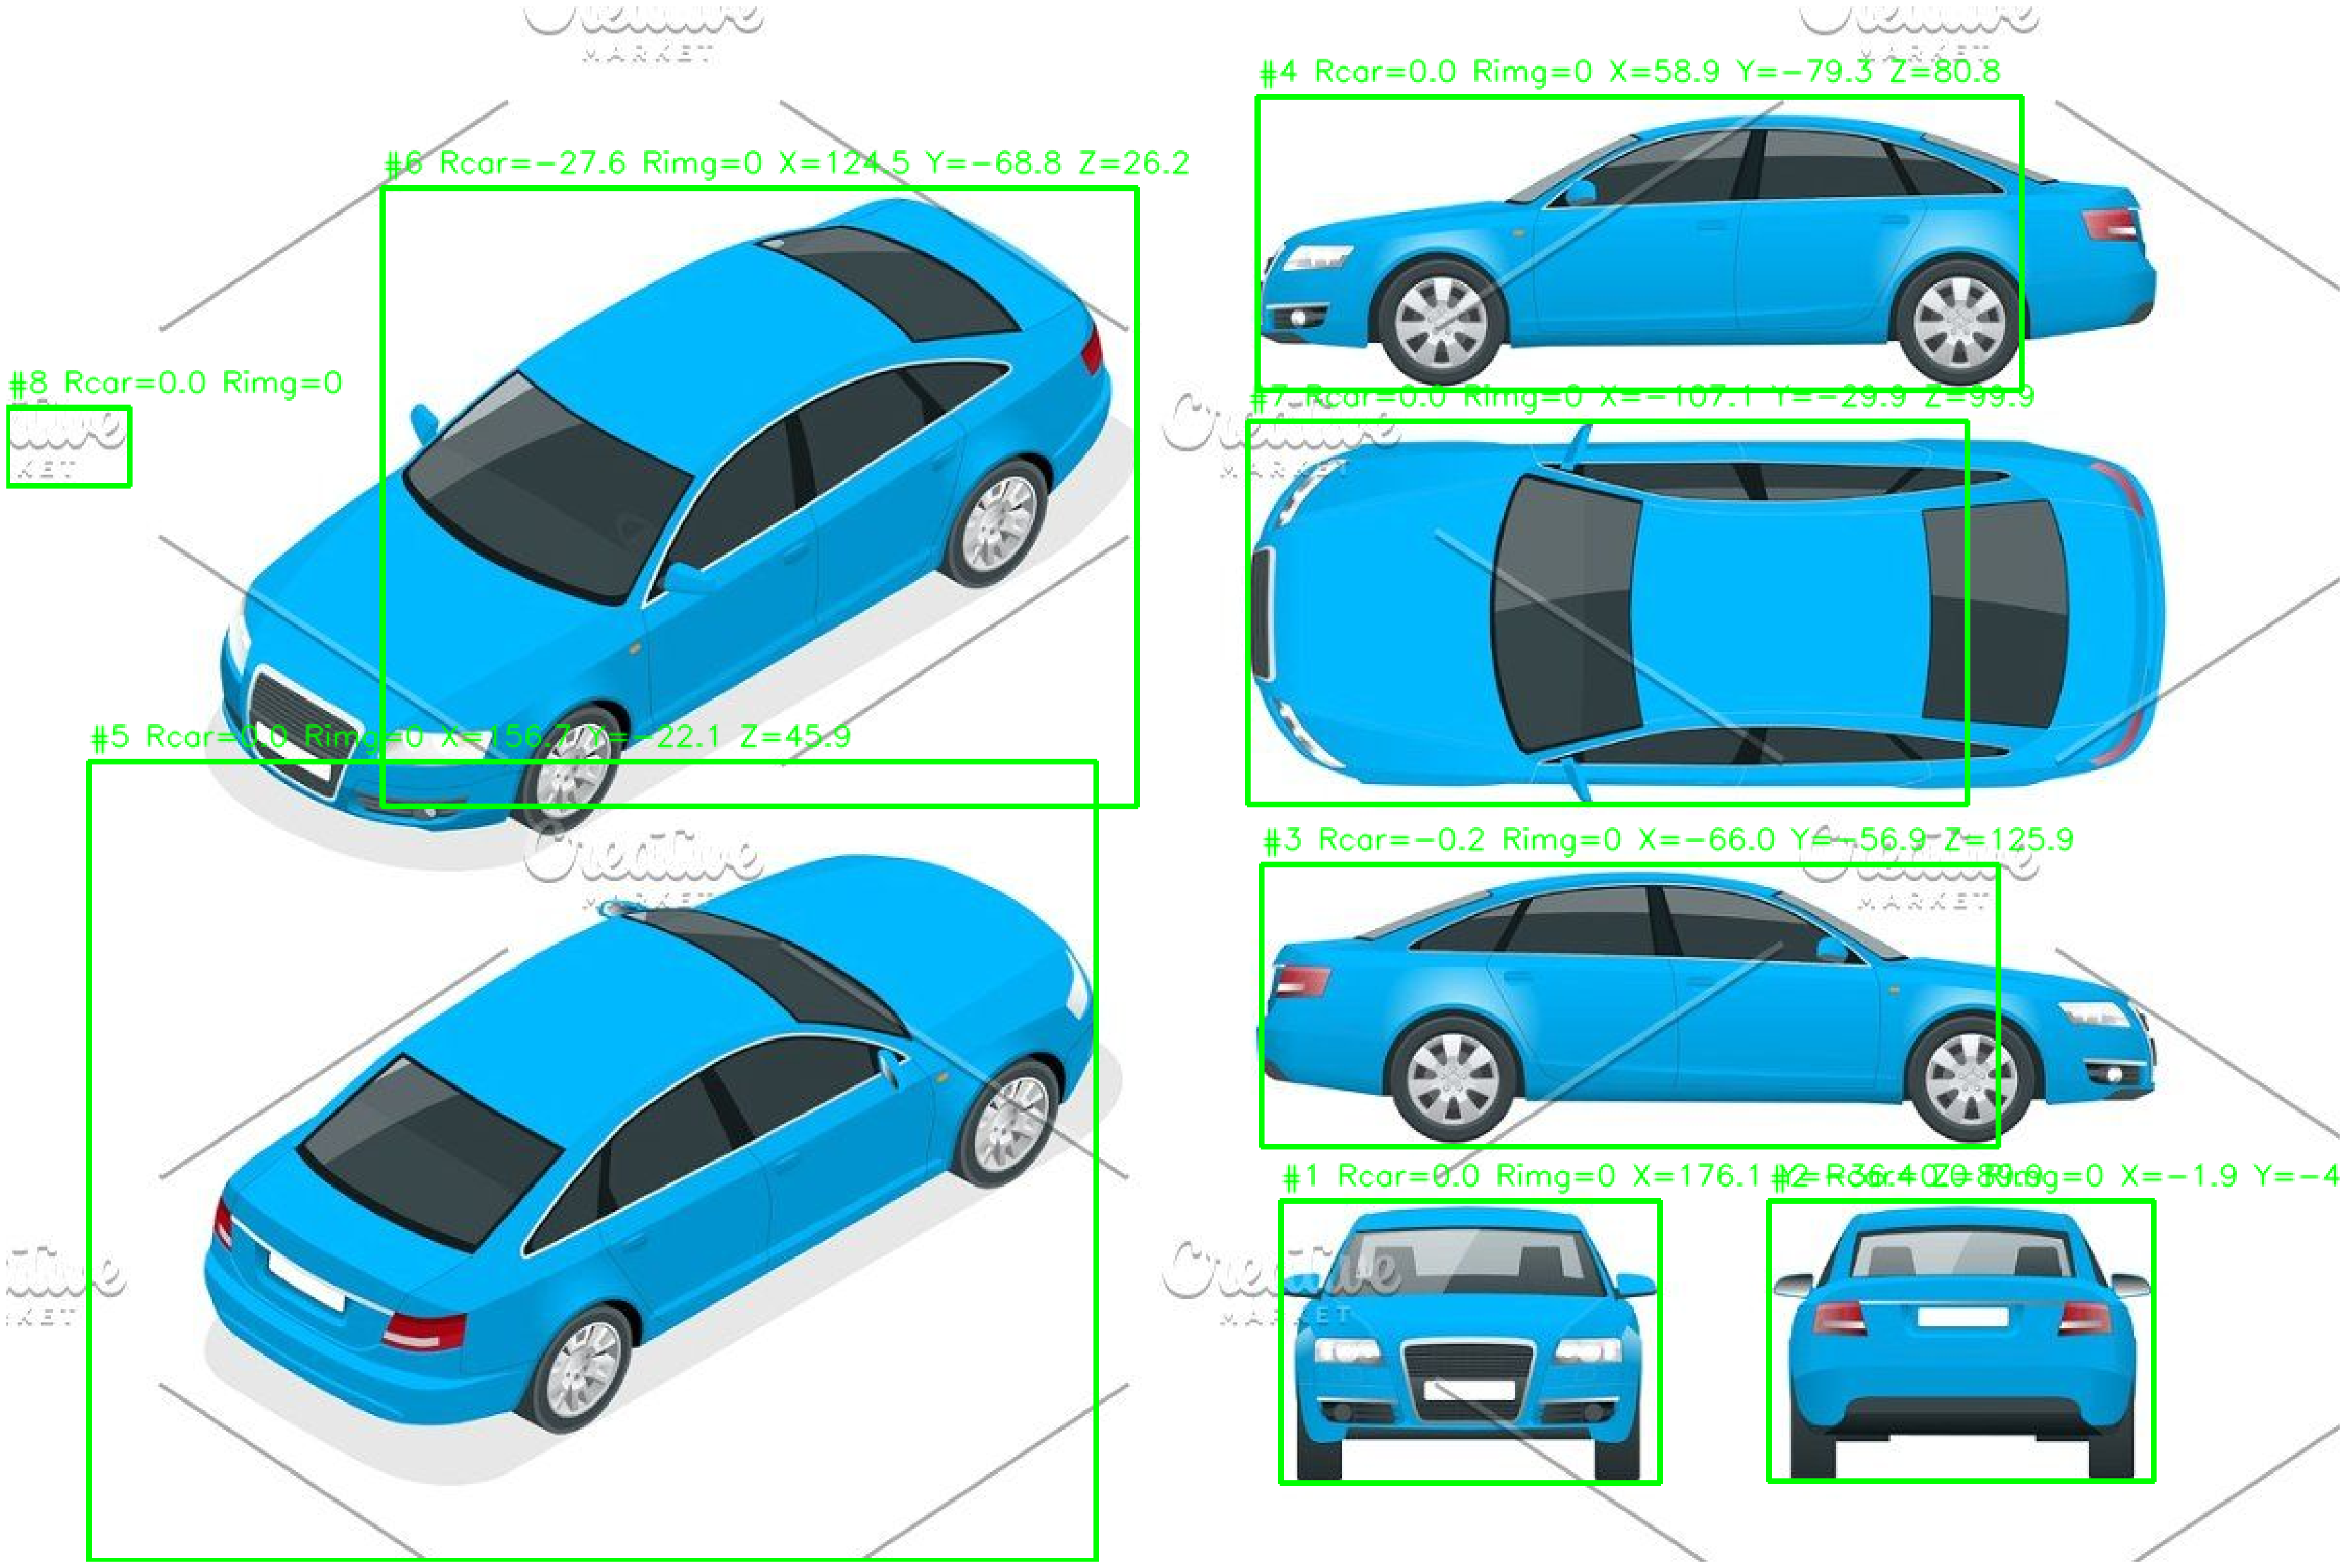

[
  {
    "id": 1,
    "bbox": [
      655,
      614,
      850,
      759
    ],
    "conf": 0.861,
    "X-pos": 176.102,
    "Y-pos": -36.409,
    "Z-pos": 89.934,
    "R-pos": 0.0,
    "pose_src": "local",
    "sin_yaw": 0.067972,
    "cos_yaw": -0.997687,
    "sin_pitch": -0.593548,
    "cos_pitch": 0.804799,
    "sin_roll": 0.999999,
    "cos_roll": 0.001151,
    "R-img": 0,
    "R-car": 0.0
  },
  {
    "id": 2,
    "bbox": [
      906,
      614,
      1104,
      758
    ],
    "conf": 0.818,
    "X-pos": -1.931,
    "Y-pos": -42.956,
    "Z-pos": 87.01,
    "R-pos": 0.0,
    "pose_src": "local",
    "sin_yaw": -0.033702,
    "cos_yaw": 0.999432,
    "sin_pitch": -0.681439,
    "cos_pitch": 0.731875,
    "sin_roll": 0.998638,
    "cos_roll": 0.05217,
    "R-img": 0,
    "R-car": 0.0
  },
  {
    "id": 3,
    "bbox": [
      645,
      441,
      1024,
      586
    ],
    "conf": 0.675,
    "X-pos": -65.959,
    "Y-pos": -56.915,
    "Z-pos": 125.932,
    "R-pos": -0.227,
    

In [33]:
# Глобально: храним последнюю загрузку и декодированные картинки
UPLOADED_BYTES = {}
UPLOADED_IMAGES = {}

def run_pipeline():
    global UPLOADED_BYTES, UPLOADED_IMAGES
    UPLOADED_BYTES = files.upload()
    UPLOADED_IMAGES = {}

    for fn, data in UPLOADED_BYTES.items():
        img = read_image_auto(data)
        if img is None:
            print(f"{fn}: не удалось прочитать файл")
            continue

        UPLOADED_IMAGES[fn] = img  # <- это и будет использовано графиками

        vis, rows = process_image(img)
        if vis is None:
            print(f"{fn}: ошибка обработки")
            continue

        plt.figure(figsize=(80,32))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        df = pd.DataFrame(rows)
        try:
            from google.colab import data_table
            data_table.DataTable(df, include_index=False)
        except Exception:
            pass

        print(json.dumps(rows, ensure_ascii=False, indent=2))

run_pipeline()

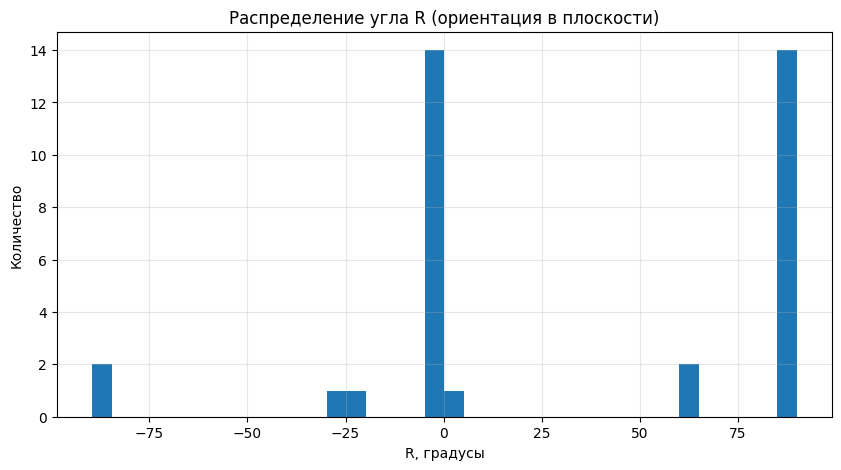

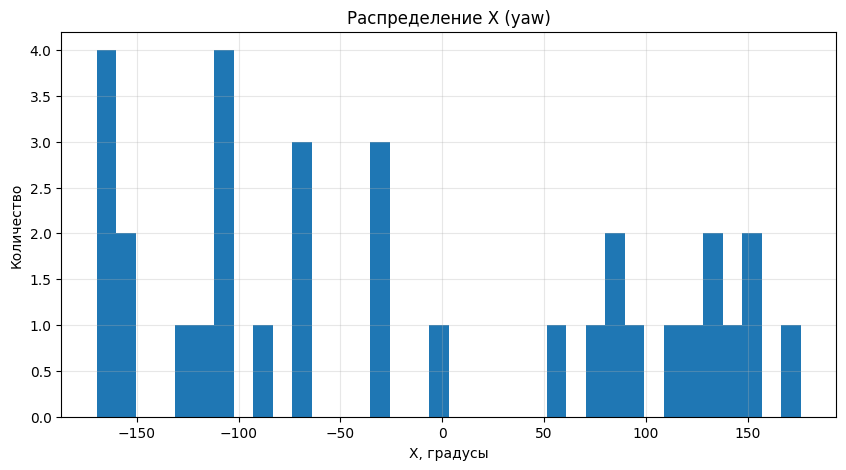

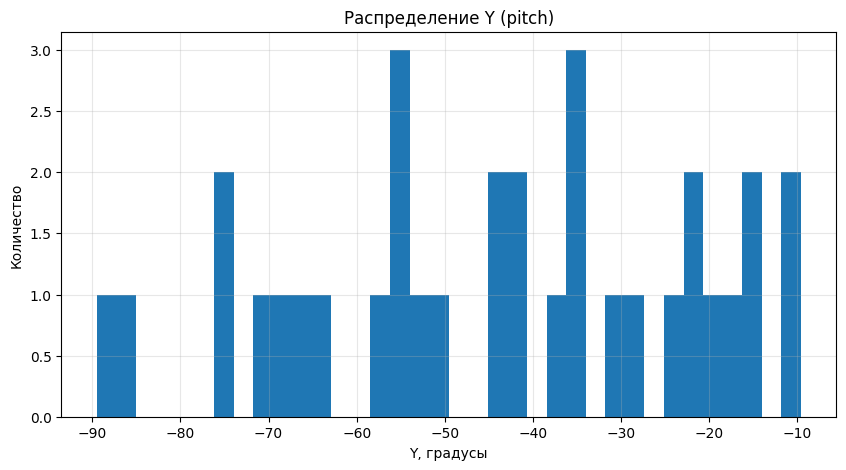

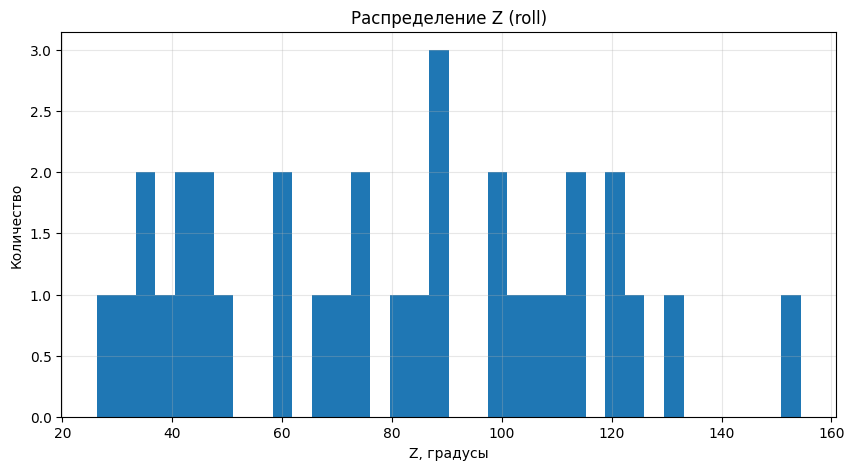

/tmp/ipython-input-1949876721.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = pd.DataFrame({"xbin": cats, "y": y}).groupby("xbin")["y"]


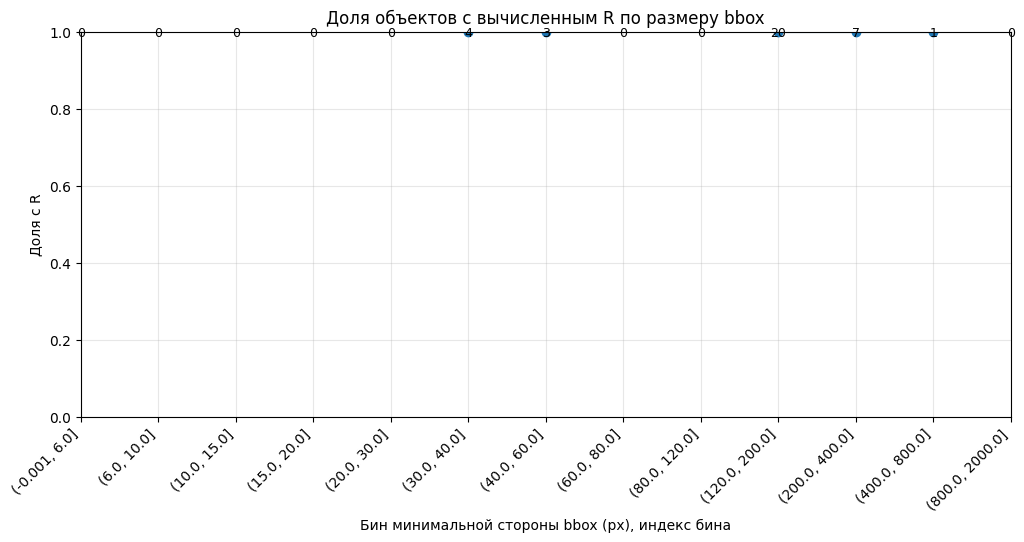

/tmp/ipython-input-1949876721.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = pd.DataFrame({"xbin": cats, "y": y}).groupby("xbin")["y"]


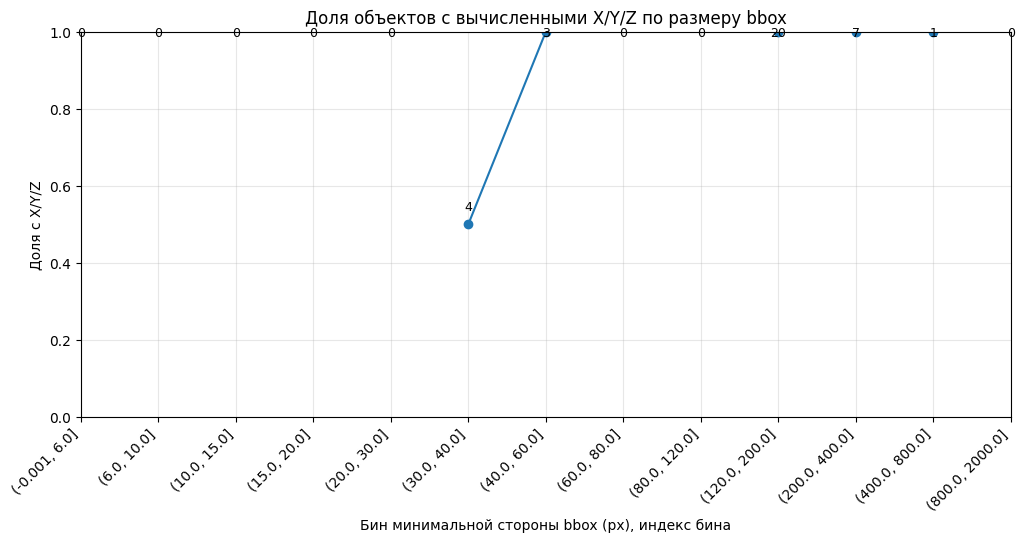

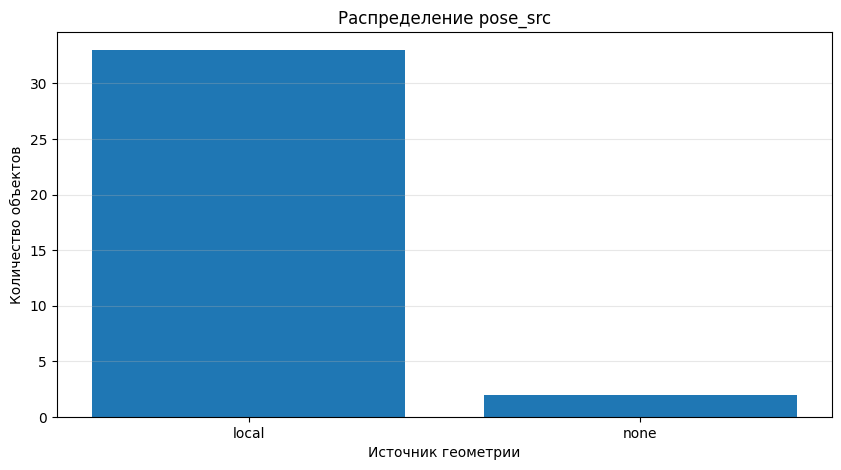

/tmp/ipython-input-1949876721.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


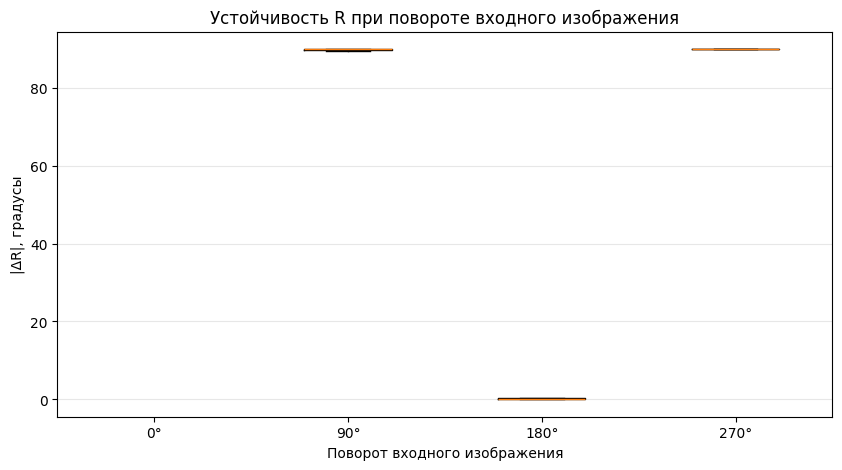

/tmp/ipython-input-1949876721.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


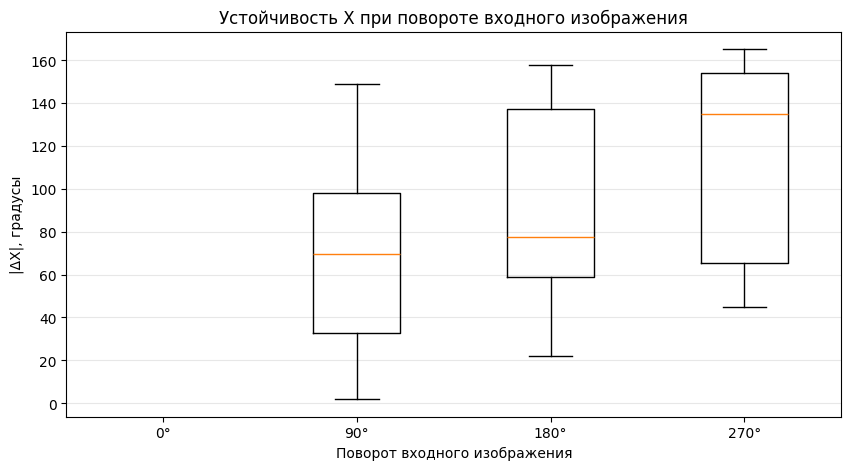

/tmp/ipython-input-1949876721.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


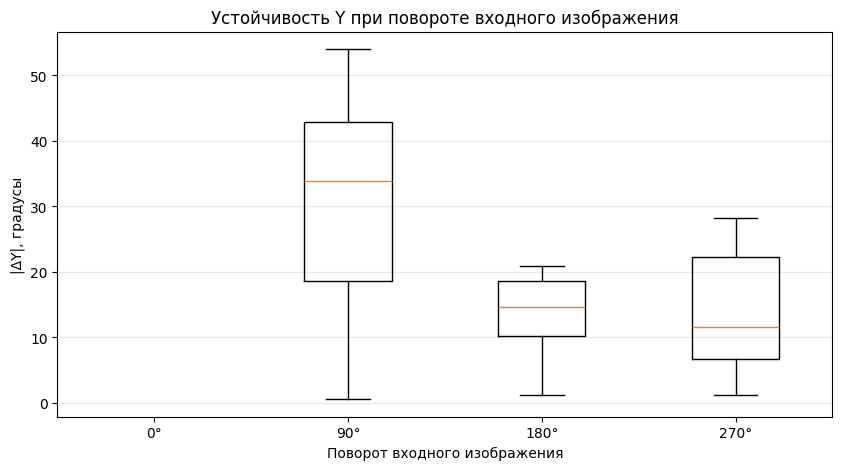

/tmp/ipython-input-1949876721.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


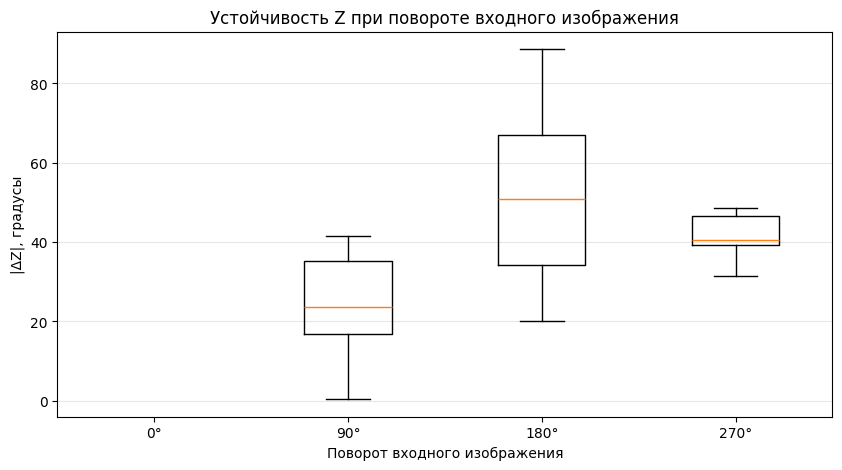

Графики построены. Итоговый DataFrame df доступен в переменной df внутри функции.


In [34]:
# ГРАФИКИ
def _ang_diff_deg(a, b):
    if a is None or b is None:
        return None
    if (not np.isfinite(a)) or (not np.isfinite(b)):
        return None
    d = (float(a) - float(b) + 180.0) % 360.0 - 180.0
    return abs(d)

def _iou_xyxy_int(a, b):
    ax1, ay1, ax2, ay2 = map(int, a)
    bx1, by1, bx2, by2 = map(int, b)
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    au = max(0, ax2 - ax1) * max(0, ay2 - ay1)
    bu = max(0, bx2 - bx1) * max(0, by2 - by1)
    return inter / (au + bu - inter + 1e-9)

def _bbox_min_side(row):
    x1, y1, x2, y2 = row["bbox"]
    return float(min(max(0, x2 - x1), max(0, y2 - y1)))

def _rotate_image_k90(img_bgr, k):
    return rotate_k90_bgr(img_bgr, k)

def _map_bbox_to_base(bbox_xyxy, W_base, H_base, k_applied):
    """
    bbox_xyxy задан в координатах изображения, полученного поворотом base на k_applied*90 (CW).
    Возвращает bbox в координатах base.
    """
    k_inv = (-int(k_applied)) % 4
    if k_applied % 2 == 0:
        W_from, H_from = W_base, H_base
    else:
        W_from, H_from = H_base, W_base
    bbox_base, _, _ = bbox_rotate_k90(bbox_xyxy, W_from, H_from, k_inv)
    x1, y1, x2, y2 = bbox_base
    x1 = max(0, min(int(x1), W_base - 1))
    x2 = max(0, min(int(x2), W_base - 1))
    y1 = max(0, min(int(y1), H_base - 1))
    y2 = max(0, min(int(y2), H_base - 1))
    return [x1, y1, x2, y2]

def _rows_to_df(rows, file_name):
    if not rows:
        return pd.DataFrame(columns=[
            "file", "id", "conf", "bbox", "bbox_min_side",
            "X-pos", "Y-pos", "Z-pos", "R-pos", "R-img",
            "pose_src"
        ])
    df = pd.DataFrame(rows)
    df["file"] = file_name
    df["bbox_min_side"] = df.apply(_bbox_min_side, axis=1)
    return df

def _plot_hist(series, title, xlabel, bins=36):
    s = pd.to_numeric(series, errors="coerce").dropna().values
    if len(s) == 0:
        print(f"Нет данных для графика: {title}")
        return
    plt.figure(figsize=(10, 5))
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Количество")
    plt.grid(True, alpha=0.3)
    plt.show()

def _plot_bar_counts(labels, counts, title, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    x = np.arange(len(labels))
    plt.bar(x, counts)
    plt.xticks(x, labels, rotation=0)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

def _plot_rate_by_bins(df, x_col, y_bool_col, bins, title, xlabel, ylabel):
    x = pd.to_numeric(df[x_col], errors="coerce")
    y = df[y_bool_col].astype(bool)
    ok = x.notna()
    x = x[ok]
    y = y[ok]
    if len(x) == 0:
        print(f"Нет данных для графика: {title}")
        return

    cats = pd.cut(x, bins=bins, include_lowest=True)
    grp = pd.DataFrame({"xbin": cats, "y": y}).groupby("xbin")["y"]
    rate = grp.mean()
    n = grp.size()

    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(len(rate)), rate.values, marker="o")
    plt.ylim(0.0, 1.0)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.xticks(np.arange(len(rate)), [f"{i}" for i in rate.index.astype(str)], rotation=45, ha="right")
    for i, (rv, nn) in enumerate(zip(rate.values, n.values)):
        plt.text(i, min(0.98, rv + 0.03), str(int(nn)), ha="center", va="bottom", fontsize=9)
    plt.show()

def _plot_boxplot_by_rotation(deltas_by_k, title, ylabel):
    ks = sorted(deltas_by_k.keys())
    data = [np.asarray(deltas_by_k[k], dtype=float) for k in ks]
    labels = [f"{k*90}°" for k in ks]
    data = [d[~np.isnan(d)] for d in data]
    if all(len(d) == 0 for d in data):
        print(f"Нет данных для графика: {title}")
        return
    plt.figure(figsize=(10, 5))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(title)
    plt.xlabel("Поворот входного изображения")
    plt.ylabel(ylabel)
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

def evaluate_and_plot_graphs(iou_match_thr=0.3, rotate_test=True):
    """
    Загружает изображения, прогоняет process_image и строит графики.
    rotate_test=True добавляет прогон на 0/90/180/270 и оценку устойчивости по IoU-сопоставлению.
    """

    global UPLOADED_IMAGES
    all_df = []
    inv_records = []  # пары (file, rot_k_input, ref_id, match_id, dR, dX, dY, dZ)

    for fn, img in UPLOADED_IMAGES.items():
        if img is None:
            print(f"{fn}: изображение пустое")
            continue

        H0, W0 = img.shape[:2]

        vis0, rows0 = process_image(img)
        df0 = _rows_to_df(rows0, fn)
        df0["input_rot_k"] = 0
        if "pose_src" not in df0.columns:
            df0["pose_src"] = "none"
        all_df.append(df0)

        if rotate_test:
            ref = df0.copy()
            ref["ref_idx"] = np.arange(len(ref))
            ref_boxes = ref["bbox"].tolist()

            for k_in in [1, 2, 3]:
                imgk = _rotate_image_k90(img, k_in)
                visk, rowsk = process_image(imgk)
                dfk = _rows_to_df(rowsk, fn)
                dfk["input_rot_k"] = k_in

                if len(dfk) == 0:
                    all_df.append(dfk)
                    continue

                mapped_boxes = []
                for bb in dfk["bbox"].tolist():
                    mapped_boxes.append(_map_bbox_to_base(bb, W0, H0, k_in))
                dfk["bbox_base"] = mapped_boxes

                for j, rowk in dfk.iterrows():
                    bbk = rowk["bbox_base"]
                    best_iou = -1.0
                    best_i = None
                    for i, bbr in enumerate(ref_boxes):
                        iou = _iou_xyxy_int(bbk, bbr)
                        if iou > best_iou:
                            best_iou = iou
                            best_i = i
                    if best_i is None or best_iou < iou_match_thr:
                        continue

                    rr = ref.iloc[best_i]
                    dR = _ang_diff_deg(rowk.get("R-pos", None), rr.get("R-pos", None))
                    dX = _ang_diff_deg(rowk.get("X-pos", None), rr.get("X-pos", None))
                    dY = _ang_diff_deg(rowk.get("Y-pos", None), rr.get("Y-pos", None))
                    dZ = _ang_diff_deg(rowk.get("Z-pos", None), rr.get("Z-pos", None))

                    inv_records.append({
                        "file": fn,
                        "input_rot_deg": int(k_in * 90),
                        "match_iou": float(best_iou),
                        "dR": dR,
                        "dX": dX,
                        "dY": dY,
                        "dZ": dZ
                    })

                all_df.append(dfk.drop(columns=["bbox_base"], errors="ignore"))

    if not all_df:
        print("Нет данных для построения графиков")
        return

    df = pd.concat(all_df, ignore_index=True)
    for col in ["X-pos", "Y-pos", "Z-pos", "R-pos", "conf", "bbox_min_side"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df["has_R"] = df["R-pos"].notna()
    df["has_XYZ"] = df["X-pos"].notna() & df["Y-pos"].notna() & df["Z-pos"].notna()

    # 1) Распределение R
    if "R-pos" in df.columns:
        _plot_hist(df["R-pos"], "Распределение угла R (ориентация в плоскости)", "R, градусы", bins=36)

    # 2) Распределения X/Y/Z
    if "X-pos" in df.columns:
        _plot_hist(df["X-pos"], "Распределение X (yaw)", "X, градусы", bins=36)
    if "Y-pos" in df.columns:
        _plot_hist(df["Y-pos"], "Распределение Y (pitch)", "Y, градусы", bins=36)
    if "Z-pos" in df.columns:
        _plot_hist(df["Z-pos"], "Распределение Z (roll)", "Z, градусы", bins=36)

    # 3) Доля валидных оценок по размеру bbox
    bins = [0, 6, 10, 15, 20, 30, 40, 60, 80, 120, 200, 400, 800, 2000]
    _plot_rate_by_bins(
        df, "bbox_min_side", "has_R", bins=bins,
        title="Доля объектов с вычисленным R по размеру bbox",
        xlabel="Бин минимальной стороны bbox (px), индекс бина",
        ylabel="Доля с R"
    )
    _plot_rate_by_bins(
        df, "bbox_min_side", "has_XYZ", bins=bins,
        title="Доля объектов с вычисленными X/Y/Z по размеру bbox",
        xlabel="Бин минимальной стороны bbox (px), индекс бина",
        ylabel="Доля с X/Y/Z"
    )

    # 4) Частоты источников позы
    if "pose_src" in df.columns:
        vc = df["pose_src"].fillna("none").value_counts()
        _plot_bar_counts(
            labels=vc.index.tolist(),
            counts=vc.values.tolist(),
            title="Распределение pose_src",
            xlabel="Источник геометрии",
            ylabel="Количество объектов"
        )

    # 5) Устойчивость к повороту входного изображения (если включено)
    if rotate_test and inv_records:
        inv = pd.DataFrame(inv_records)
        for c in ["dR", "dX", "dY", "dZ"]:
            inv[c] = pd.to_numeric(inv[c], errors="coerce")

        deltas_R = {0: [], 1: [], 2: [], 3: []}
        deltas_X = {0: [], 1: [], 2: [], 3: []}
        deltas_Y = {0: [], 1: [], 2: [], 3: []}
        deltas_Z = {0: [], 1: [], 2: [], 3: []}

        for deg in [90, 180, 270]:
            k = deg // 90
            sub = inv[inv["input_rot_deg"] == deg]
            deltas_R[k] = sub["dR"].dropna().astype(float).tolist()
            deltas_X[k] = sub["dX"].dropna().astype(float).tolist()
            deltas_Y[k] = sub["dY"].dropna().astype(float).tolist()
            deltas_Z[k] = sub["dZ"].dropna().astype(float).tolist()

        _plot_boxplot_by_rotation(deltas_R, "Устойчивость R при повороте входного изображения", "|ΔR|, градусы")
        _plot_boxplot_by_rotation(deltas_X, "Устойчивость X при повороте входного изображения", "|ΔX|, градусы")
        _plot_boxplot_by_rotation(deltas_Y, "Устойчивость Y при повороте входного изображения", "|ΔY|, градусы")
        _plot_boxplot_by_rotation(deltas_Z, "Устойчивость Z при повороте входного изображения", "|ΔZ|, градусы")

    print("Графики построены. Итоговый DataFrame df доступен в переменной df внутри функции.")

# Запуск построения графиков
evaluate_and_plot_graphs(iou_match_thr=0.3, rotate_test=True)